<h1 align="center"> Ensemble Learning</h1>
<h3 align="center"> Evan Ditter </h3>
<h3 align="center">March 25th, 2019</h3>

## Overview
In this lab, I will explore ensemble learning on a dataset of various types of mushrooms. The goal is to be able to determine whether or not a mushroom is edible or poisonous based upon its physical attributes.

The first part of the lab will focus on classification through multiple linear regressions. Since the data is not in numerical form, I will have to create dummy variables to represent each different option before performing the regressions. I will then analyze the results with a ROC curve and the Adjust R-squared value. 

In the second part of the lab, I will use XGBoost to create a model. For more information on XGBoost visit the links below.

In both models, I will analyze the prediction capabilities and output the variable importance and compare them against one another.

**References**:   
https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/  
https://github.com/dmlc/xgboost/tree/master/demo/rank   
https://xgboost.readthedocs.io/en/latest/get_started.html  
https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/springerEBR09.pdf  
https://www.kaggle.com/uciml/mushroom-classification  

## Data
**Definitions**:

Ensemble Learning - Ensemble learning is a machine learning paradigm where multiple learners are trained to solve the same problem. In contrast to ordinary machine learning approaches which try to learn one hypothesis from training data, ensemble methods try to construct a set of hypotheses and combine them to use.

Linear Regression - Linear regression attempts to model the relationship between two (or more) variables by fitting a linear equation to observed data.  

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
import xgboost as xgb

df = pd.read_csv('mushrooms.csv')

dtrain = xgb.DMatrix('agaricus.txt.train')
dtest = xgb.DMatrix('agaricus.txt.test')
df.columns= ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 
            'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
            'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 
            'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
df.head()

[21:00:12] 6513x127 matrix with 143286 entries loaded from agaricus.txt.train
[21:00:12] 1611x127 matrix with 35442 entries loaded from agaricus.txt.test


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


**About the data**    
Attribute Information: (classes: edible=e, poisonous=p)  
cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s  
cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s  
cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y  
bruises: bruises=t,no=f  
odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s  
gill-attachment: attached=a,descending=d,free=f,notched=n  
gill-spacing: close=c,crowded=w,distant=d  
gill-size: broad=b,narrow=n  
gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y  
stalk-shape: enlarging=e,tapering=t  
stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?  
stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s  
stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s  
stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y  
stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y  
veil-type: partial=p,universal=u  
veil-color: brown=n,orange=o,white=w,yellow=y  
ring-number: none=n,one=o,two=t  
ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z  
spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y  
population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y  
habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d  

## Exploratory Data Analysis and Models

### Linear Regression Models
I will begin with several multiple linear regressions on the data not using xgboost. To start, I need to create dummy variables for each potential value in each attribute. For example, the cap-shape attribute can be bell=b, conical=c, convex=x, flat=f, knobbed=k, or sunken=s. Each of these values will become its own dummy variable when performing the linear regressions. The first regression I will do is with all of the attributes present.

In [316]:
target = pd.DataFrame(dummy, columns=['class'])

data = pd.get_dummies(data=df, columns=['class','cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 
            'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
            'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 
            'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'])

X = data.drop(['class_e', 'class_p'], axis=1)
y = data.iloc[:,0:1]

model = sm.OLS(y, X).fit()
all_predictions = model.predict(X)
model.summary()
# all_predictions
# 1 is edible and 0 is poisonous 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                class_e   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.676e+29
Date:                Mon, 25 Mar 2019   Prob (F-statistic):               0.00
Time:                        18:12:36   Log-Likelihood:             2.5458e+05
No. Observations:                8124   AIC:                        -5.090e+05
Df Residuals:                    8038   BIC:                        -5.084e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
cap-shape_b                    0.0113   6.73e-16   1.68e+13      0.000       0.011       0.011
cap-shape_c                    0.0113    2.9e-15    3.9e+12      0.000       0.011       0.011
cap-shape_f                    0.0113   6.18e-16   1.83e+13      0.000       0.011       0.011
cap-shape_k                    0.0113   6.38e-16   1.77e+13      0.000       0.011       0.011
cap-shape_s                    0.0113   1.23e-15    9.2e+12      0.000       0.011       0.011
cap-shape_x                    0.0113   6.16e-16   1.83e+13      0.000       0.011       0.011
cap-surface_f                  0.0170   1.02e-15   1.67e+13      0.000       0.017       0.017
cap-surface_g                  0.0170   3.22e-15   5.26e+12      0.000       0.017       0.017
cap-surface_s                  0.0170   1.02e-15   1.67e+13      0.000       0.017       0.017
cap-surface_y                  0.0170   1.01e-15   1.68e+13      0.000       0.017       0.017
cap-color_b                    0.0068   6.32e-16   1.07e+13      0.000       0.007       0.007
cap-color_c                    0.0068   1.13e-15   6.01e+12      0.000       0.007       0.007
cap-color_e                    0.0068    4.5e-16   1.51e+13      0.000       0.007       0.007
cap-color_g                    0.0068   4.26e-16   1.59e+13      0.000       0.007       0.007
cap-color_n                    0.0068    4.3e-16   1.58e+13      0.000       0.007       0.007
cap-color_p                    0.0068   6.57e-16   1.03e+13      0.000       0.007       0.007
cap-color_r                    0.0068   1.82e-15   3.72e+12      0.000       0.007       0.007
cap-color_u                    0.0068   1.82e-15   3.72e+12      0.000       0.007       0.007
cap-color_w                    0.0068   4.27e-16   1.59e+13      0.000       0.007       0.007
cap-color_y                    0.0068   4.64e-16   1.46e+13      0.000       0.007       0.007
bruises_f                      0.4068   1.03e-15   3.95e+14      0.000       0.407       0.407
bruises_t                     -0.3390   9.48e-16  -3.58e+14      0.000      -0.339      -0.339
odor_a                         0.4286   1.14e-15   3.77e+14      0.000       0.429       0.429
odor_c                        -1.4989   3.55e-15  -4.23e+14      0.000      -1.499      -1.499
odor_f                        -0.0041    1.2e-15  -3.44e+12      0.000      -0.004      -0.004
odor_l                         0.4286   1.14e-15   3.77e+14      0.000       0.429       0.429
odor_m                        -0.0260   3.85e-16  -6.74e+13      0.000      -0.026      -0.026
odor_n                         0.5011   6.78e-16   7.39e+14      0.000       0.501       0.501
odor_p                         0.2469   2.08e-15   1.19e+14      0.000       0.247       0.247
odor_s                        -0.0041   1.2

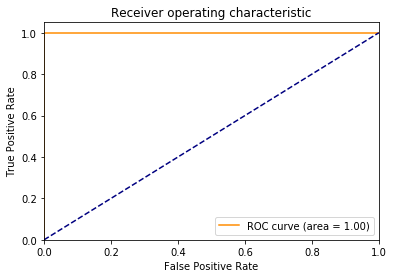

In [317]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [220]:
all_predictions.head()

0   -5.696832e-15
1    1.000000e+00
2    1.000000e+00
3   -5.696832e-15
4    1.000000e+00
dtype: float64

Above there are several performance measures for a multiple linear regression that uses all of the attributes in the mushroom dataset. The ROC curve shows that having all the attributes produces an area of 1.00 which also coincides with the results that the R-squared value is 1.00. This leads to the conclusion that knowning all the physical attributes of a mushroom will give a 100 percent success rate in depicting whether or not a mushroom is poisonous. 

Next, I will group all the cap related data and perform a regression. 

In [379]:
capX = data.iloc[:,2:22]
capy = data.iloc[:,0:1]

model = sm.OLS(capy, capX).fit()
cap_predictions = model.predict(capX)
model.summary()
#predictions

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                class_e   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     80.34
Date:                Mon, 25 Mar 2019   Prob (F-statistic):          3.40e-258
Time:                        19:04:20   Log-Likelihood:                -5258.6
No. Observations:                8124   AIC:                         1.055e+04
Df Residuals:                    8106   BIC:                         1.068e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
cap-shape_b       0.5594      0.043     12.907      0.000       0.474       0.644
cap-shape_c      -0.1641      0.209     -0.787      0.431      -0.573       0.245
cap-shape_f       0.1081      0.039      2.751      0.006       0.031       0.185
cap-shape_k      -0.0872      0.041     -2.109      0.035      -0.168      -0.006
cap-shape_s       0.4144      0.082      5.037      0.000       0.253       0.576
cap-shape_x       0.1379      0.039      3.515      0.000       0.061       0.215
cap-surface_f     0.5521      0.043     12.886      0.000       0.468       0.636
cap-surface_g    -0.2324      0.205     -1.135      0.257      -0.634       0.169
cap-surface_s     0.2939      0.043      6.893      0.000       0.210       0.378
cap-surface_y     0.3549      0.042      8.381      0.000       0.272       0.438
cap-color_b      -0.1544      0.039     -4.002      0.000      -0.230      -0.079
cap-color_c       0.2584      0.067      3.857      0.000       0.127       0.390
cap-color_e      -0.0381      0.023     -1.680      0.093      -0.083       0.006
cap-color_g      -0.0110      0.022     -0.495      0.621      -0.055       0.033
cap-color_n       0.0779      0.022      3.609      0.000       0.036       0.120
cap-color_p      -0.1208      0.041     -2.980      0.003      -0.200      -0.041
cap-color_r       0.5221      0.108      4.837      0.000       0.311       0.734
cap-color_u       0.5221      0.108      4.837      0.000       0.311       0.734
cap-color_w       0.1284      0.024      5.449      0.000       0.082       0.175
cap-color_y      -0.2162      0.024     -9.138      0.000      -0.263      -0.170
==============================================================================
Omnibus:                        2.467   Durbin-Watson:                   1.318
Prob(Omnibus):                  0.291   Jarque-Bera (JB):              757.969
Skew:                           0.043   Prob(JB):                    2.56e-165
Kurtosis:                       1.506   Cond. No.                     3.41e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.54e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

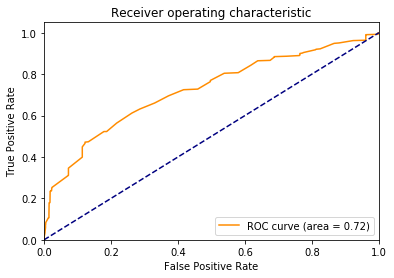

In [380]:
fpr, tpr, thresholds = roc_curve(capy, cap_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [282]:
cap_predictions.head()

0    2.109424e-15
1    1.000000e+00
2    1.000000e+00
3    3.330669e-15
4    1.000000e+00
dtype: float64

Here it can be seen that just the cap related physical attributes of a mushroom a ROC curve area of 0.72 and the adjust R-squared value is again 0.142. Thus, the cap of a mushroom is not a very good predictor of whether or not it is poisonous.

Next, I will look at how mushrooms that are either bruised or not bruised affect the prediction of poisonous or non-poisonous.

In [285]:
bruiseX = data.iloc[:,22:24]
bruisey = data.iloc[:,0:1]

model = sm.OLS(bruisey, bruiseX).fit()
bruise_predictions = model.predict(bruiseX)
model.summary()
#predictions

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                class_e   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     2730.
Date:                Mon, 25 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:49:05   Log-Likelihood:                -4714.2
No. Observations:                8124   AIC:                             9432.
Df Residuals:                    8122   BIC:                             9446.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bruises_f      0.3067      0.006     48.874      0.000       0.294       0.319
bruises_t      0.8152      0.007    109.551      0.000       0.801       0.830
==============================================================================
Omnibus:                      505.644   Durbin-Watson:                   1.437
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.131
Skew:                           0.106   Prob(JB):                     4.25e-43
Kurtosis:                       2.271   Cond. No.                         1.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

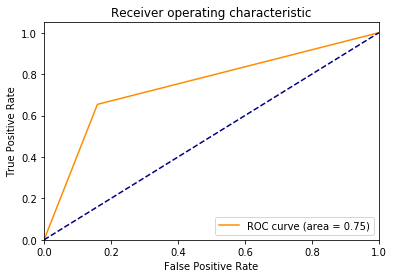

In [319]:
fpr, tpr, thresholds = roc_curve(bruisey, bruise_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [286]:
bruise_predictions.head()

0    0.815166
1    0.815166
2    0.815166
3    0.815166
4    0.306655
dtype: float64

Bruises produce an ROC curve of 0.75 and an Adjusted R-squared value of 0.251. This model only has two variables so it makes sense for it to not be a 100 percent accurate prediction. 

Next, I will go over how mushroom odors affect the poisonous outcome. 

In [320]:
odorX = data.iloc[:,24:33]
odory = data.iloc[:,0:1]

model = sm.OLS(odory, odorX).fit()
odor_predictions = model.predict(odorX)
model.summary()
#predictions

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                class_e   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 1.674e+04
Date:                Mon, 25 Mar 2019   Prob (F-statistic):               0.00
Time:                        18:15:52   Log-Likelihood:                 5734.8
No. Observations:                8124   AIC:                        -1.145e+04
Df Residuals:                    8115   BIC:                        -1.139e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
odor_a         1.0000      0.006    167.339      0.000       0.988       1.012
odor_c              0      0.009          0      1.000      -0.017       0.017
odor_f              0      0.003          0      1.000      -0.005       0.005
odor_l         1.0000      0.006    167.339      0.000       0.988       1.012
odor_m              0      0.020          0      1.000      -0.039       0.039
odor_n         0.9660      0.002    480.069      0.000       0.962       0.970
odor_p       5.46e-16      0.007   7.31e-14      1.000      -0.015       0.015
odor_s              0      0.005          0      1.000      -0.010       0.010
odor_y              0      0.005          0      1.000      -0.010       0.010
==============================================================================
Omnibus:                    10744.009   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1308166.853
Skew:                          -7.802   Prob(JB):                         0.00
Kurtosis:                      63.176   Cond. No.                         9.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

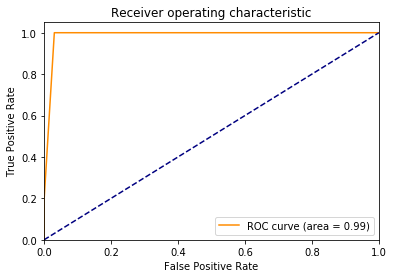

In [321]:
fpr, tpr, thresholds = roc_curve(odory, odor_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [288]:
odor_predictions.head()

0    5.460345e-16
1    1.000000e+00
2    1.000000e+00
3    5.460345e-16
4    9.659864e-01
dtype: float64

Odors alone produce a ROC curve area of 0.99 and an Adjust R-squared value of 0.943. This means odor is a great predictor of whether or not a mushroom is poisonous, but odor alone is not a 100 percent perfect fit.

Next, I will go over the gill attributes for mushrooms.

In [289]:
gillX = data.iloc[:,33:51]
gilly = data.iloc[:,0:1]

model = sm.OLS(gilly, gillX).fit()
gill_predictions = model.predict(gillX)
model.summary()
#predictions

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                class_e   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     866.9
Date:                Mon, 25 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:49:16   Log-Likelihood:                -2174.6
No. Observations:                8124   AIC:                             4379.
Df Residuals:                    8109   BIC:                             4484.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
gill-attachment_a     0.2676      0.022     12.198      0.000       0.225       0.311
gill-attachment_f     0.1396      0.014      9.890      0.000       0.112       0.167
gill-spacing_c        0.0027      0.006      0.442      0.659      -0.009       0.015
gill-spacing_w        0.4045      0.008     50.667      0.000       0.389       0.420
gill-size_b           0.4386      0.007     65.227      0.000       0.425       0.452
gill-size_n          -0.0314      0.009     -3.507      0.000      -0.049      -0.014
gill-color_b         -0.1109      0.016     -7.065      0.000      -0.142      -0.080
gill-color_e          0.4191      0.031     13.358      0.000       0.358       0.481
gill-color_g         -0.2703      0.014    -18.660      0.000      -0.299      -0.242
gill-color_h         -0.3999      0.015    -27.128      0.000      -0.429      -0.371
gill-color_k          0.1745      0.018      9.912      0.000       0.140       0.209
gill-color_n          0.2846      0.012     22.932      0.000       0.260       0.309
gill-color_o          0.2910      0.047      6.176      0.000       0.199       0.383
gill-color_p         -0.0458      0.012     -3.699      0.000      -0.070      -0.022
gill-color_r         -0.5809      0.060     -9.654      0.000      -0.699      -0.463
gill-color_u          0.3592      0.016     21.856      0.000       0.327       0.391
gill-color_w          0.2288      0.013     17.933      0.000       0.204       0.254
gill-color_y          0.0578      0.040      1.443      0.149      -0.021       0.136
==============================================================================
Omnibus:                      173.339   Durbin-Watson:                   1.450
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.194
Skew:                           0.004   Prob(JB):                     2.27e-84
Kurtosis:                       4.067   Cond. No.                     1.10e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.65e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

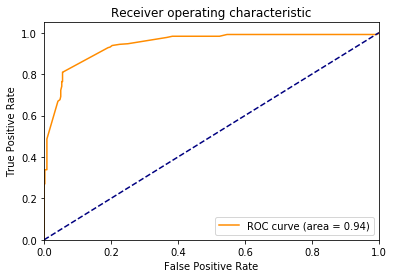

In [322]:
fpr, tpr, thresholds = roc_curve(gilly, gill_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [290]:
gill_predictions.head()

0    0.285372
1    0.755443
2    0.865585
3    0.395514
4    1.157243
dtype: float64

Gill attributes produce an ROC curve area of 0.94 and an Adjusted R-Squared value of 0.599. Gill attributes are thus a decent predictor of whether or not a mushroom is poisonous but by no means should be trusted by themselves.

Next, I will go over the stalk attributes of a mushroom.

In [307]:
stalkX = data.iloc[:,51:84]
stalky = data.iloc[:,0:1]

model = sm.OLS(stalky, stalkX).fit()
stalk_predictions = model.predict(stalkX)
model.summary()
#predicions

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                class_e   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     406.1
Date:                Mon, 25 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:55:17   Log-Likelihood:                -2590.6
No. Observations:                8124   AIC:                             5233.
Df Residuals:                    8098   BIC:                             5415.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
stalk-shape_e              -1.378e+11   2.58e+11     -0.533      0.594   -6.44e+11    3.69e+11
stalk-shape_t              -1.378e+11   2.58e+11     -0.533      0.594   -6.44e+11    3.69e+11
stalk-root_?               -1.409e+11   2.64e+11     -0.533      0.594   -6.59e+11    3.77e+11
stalk-root_b               -1.409e+11   2.64e+11     -0.533      0.594   -6.59e+11    3.77e+11
stalk-root_c               -1.409e+11   2.64e+11     -0.533      0.594   -6.59e+11    3.77e+11
stalk-root_e               -1.409e+11   2.64e+11     -0.533      0.594   -6.59e+11    3.77e+11
stalk-root_r               -1.409e+11   2.64e+11     -0.533      0.594   -6.59e+11    3.77e+11
stalk-surface-above-ring_f  4.032e+11   7.56e+11      0.533      0.594   -1.08e+12    1.89e+12
stalk-surface-above-ring_k  4.032e+11   7.56e+11      0.533      0.594   -1.08e+12    1.89e+12
stalk-surface-above-ring_s  4.032e+11   7.56e+11      0.533      0.594   -1.08e+12    1.89e+12
stalk-surface-above-ring_y  4.032e+11   7.56e+11      0.533      0.594   -1.08e+12    1.89e+12
stalk-surface-below-ring_f  1.699e+10   3.19e+10      0.533      0.594   -4.55e+10    7.94e+10
stalk-surface-below-ring_k  1.699e+10   3.19e+10      0.533      0.594   -4.55e+10    7.94e+10
stalk-surface-below-ring_s  1.699e+10   3.19e+10      0.533      0.594   -4.55e+10    7.94e+10
stalk-surface-below-ring_y  1.699e+10   3.19e+10      0.533      0.594   -4.55e+10    7.94e+10
stalk-color-above-ring_b   -5.318e+10   9.97e+10     -0.533      0.594   -2.49e+11    1.42e+11
stalk-color-above-ring_c   -7.707e+10   1.45e+11     -0.533      0.594    -3.6e+11    2.06e+11
stalk-color-above-ring_e   -5.318e+10   9.97e+10     -0.533      0.594   -2.49e+11    1.42e+11
stalk-color-above-ring_g   -5.318e+10   9.97e+10     -0.533      0.594   -2.49e+11    1.42e+11
stalk-color-above-ring_n   -5.318e+10   9.97e+10     -0.533      0.594   -2.49e+11    1.42e+11
stalk-color-above-ring_o   -8.431e+10   1.58e+11     -0.533      0.594   -3.94e+11    2.26e+11
stalk-color-above-ring_p   -5.318e+10   9.97e+10     -0.533      0.594   -2.49e+11    1.42e+11
stalk-color-above-ring_w   -5.318e+10   9.97e+10     -0.533      0.594   -2.49e+11    1.42e+11
stalk-color-above-ring_y   -5.318e+10   9.97e+10     -0.533      0.594   -2.49e+11    1.42e+11
stalk-color-below-ring_b   -8.831e+10   1.66e+11     -0.533      0.594   -4.13e+11    2.36e+11
stalk-color-below-ring_c   -6.441e+10   1.21e+11     -0.533      0.594   -3.01e+11    1.72e+11
stalk-color-below-ring_e   -8.831e+10   1.66e+11     -0.533      0.594   -4.13e+11    2.36e+11
stalk-color-below-ring_g   -8.831e+10   1.66e+11     -0.533      0.594   -4.13e+11    2.36e+11
stalk-color-below-ring_n   -8.831e+10   1.66e+11     -0.533      0.594   -4.13e+11    2.36e+11
stalk-color-below-ring_o   -5.717e+10   1.0

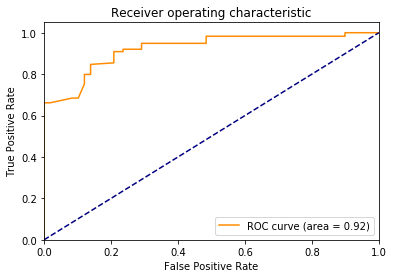

In [323]:
fpr, tpr, thresholds = roc_curve(stalky, stalk_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [325]:
stalk_predictions.head()

0    0.705063
1    1.001755
2    1.001755
3    0.705063
4    0.792953
dtype: float64

The stalk attributes produced an ROC curve area of 0.92 and an Adjusted R-squared value of 0.555. Like gills, stalks are a decent predictor of poisonous mushrooms but alone should not be trusted.

Next, I will look at veil mushroom veil's and how they affect the class attribute. 

In [373]:
veilX = data.iloc[:,84:89]
veily = data.iloc[:,0:1]

model = sm.OLS(veily, veilX).fit()
veil_predictions = model.predict(veilX)
model.summary()
#predictions

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                class_e   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     65.25
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           1.11e-41
Time:                        18:58:59   Log-Likelihood:                -5794.3
No. Observations:                8124   AIC:                         1.160e+04
Df Residuals:                    8120   BIC:                         1.162e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
veil-type_p      0.5014      0.038     13.286      0.000       0.427       0.575
veil-color_n     0.4986      0.054      9.183      0.000       0.392       0.605
veil-color_o     0.4986      0.054      9.183      0.000       0.392       0.605
veil-color_w     0.0055      0.038      0.144      0.886      -0.069       0.080
veil-color_y    -0.5014      0.140     -3.570      0.000      -0.777      -0.226
==============================================================================
Omnibus:                        1.033   Durbin-Watson:                   1.055
Prob(Omnibus):                  0.597   Jarque-Bera (JB):             1320.054
Skew:                          -0.028   Prob(JB):                    2.26e-287
Kurtosis:                       1.026   Cond. No.                     1.54e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.69e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

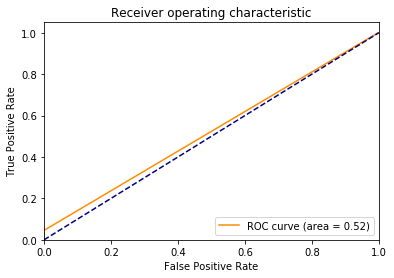

In [326]:
fpr, tpr, thresholds = roc_curve(veily, veil_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [294]:
veil_predictions.head()

0    0.506815
1    0.506815
2    0.506815
3    0.506815
4    0.506815
dtype: float64

Veil attributes produced an ROC curve area of 0.52 and an Adjusted R-Squared value of 0.023. Thus, veil attributes should be omitted from models as they generally are terrible predictors of whether or not a mushroom is poisonous.

Next, I will look at ring attributes of a mushroom.

In [295]:
ringX = data.iloc[:,89:97]
ringy = data.iloc[:,0:1]

model = sm.OLS(ringy, ringX).fit()
ring_predictions = model.predict(ringX)
model.summary()
#predictions

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                class_e   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     996.1
Date:                Mon, 25 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:49:33   Log-Likelihood:                -3947.8
No. Observations:                8124   AIC:                             7908.
Df Residuals:                    8118   BIC:                             7950.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ring-number_n  1.133e-18      0.033   3.46e-17      1.000      -0.064       0.064
ring-number_o     0.3115      0.010     30.193      0.000       0.291       0.332
ring-number_t     0.5578      0.017     33.356      0.000       0.525       0.591
ring-type_e       0.0346      0.012      2.954      0.003       0.012       0.058
ring-type_f       0.6885      0.048     14.492      0.000       0.595       0.782
ring-type_l      -0.3115      0.014    -22.833      0.000      -0.338      -0.285
ring-type_n    1.137e-18      0.033   3.47e-17      1.000      -0.064       0.064
ring-type_p       0.4576      0.011     41.087      0.000       0.436       0.479
==============================================================================
Omnibus:                      270.776   Durbin-Watson:                   1.409
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.941
Skew:                          -0.427   Prob(JB):                     4.42e-61
Kurtosis:                       2.697   Cond. No.                     4.35e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.54e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

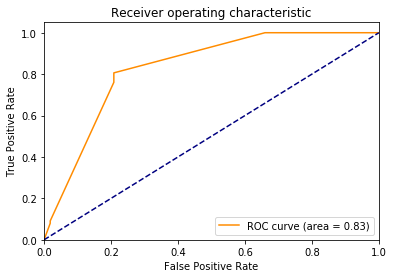

In [327]:
fpr, tpr, thresholds = roc_curve(ringy, ring_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [296]:
ring_predictions.head()

0    0.769028
1    0.769028
2    0.769028
3    0.769028
4    0.346076
dtype: float64

The ring attributes produced a ROC curve area of 0.83 and an Adjust R-sqaured value of 0.380. Thus, ring attributes are a poor predictor when compared to other attributes, but still show some type of correlation with the poisoness of a mushroom.

Next, I will explore the spore attributes of a mushroom.

In [297]:
sporeX = data.iloc[:,97:106]
sporey = data.iloc[:,0:1]

model = sm.OLS(sporey, sporeX).fit()
spore_predictions = model.predict(sporeX)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                class_e   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     1325.
Date:                Mon, 25 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:49:37   Log-Likelihood:                -2496.0
No. Observations:                8124   AIC:                             5010.
Df Residuals:                    8115   BIC:                             5073.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
spore-print-color_b     1.0000      0.048     21.047      0.000       0.907       1.093
spore-print-color_h     0.0294      0.008      3.609      0.000       0.013       0.045
spore-print-color_k     0.8803      0.008    115.709      0.000       0.865       0.895
spore-print-color_n     0.8862      0.007    119.425      0.000       0.872       0.901
spore-print-color_o     1.0000      0.048     21.047      0.000       0.907       1.093
spore-print-color_r          0      0.039          0      1.000      -0.076       0.076
spore-print-color_u     1.0000      0.048     21.047      0.000       0.907       1.093
spore-print-color_w     0.2412      0.007     35.807      0.000       0.228       0.254
spore-print-color_y     1.0000      0.048     21.047      0.000       0.907       1.093
==============================================================================
Omnibus:                      477.058   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1950.795
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                       5.390   Cond. No.                         7.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

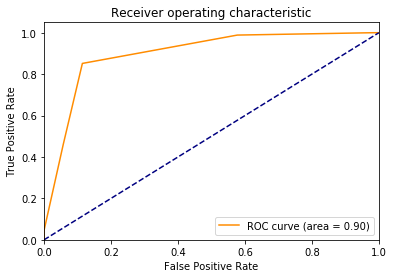

In [328]:
fpr, tpr, thresholds = roc_curve(sporey, spore_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [298]:
spore_predictions.head()

0    0.880342
1    0.886179
2    0.886179
3    0.880342
4    0.886179
dtype: float64

The spore attributes produced a ROC curve area of 0.90 and an Adjusted R-squared value of 0.566. Thus, spore attributes are a decently good predictor of the poisoness of mushrooms but not as good as some of the other attributes.

I will next look at the population attibutes for mushrooms.

In [299]:
popX = data.iloc[:,106:112]
popy = data.iloc[:,0:1]

model = sm.OLS(popy, popX).fit()
pop_predictions = model.predict(popX)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                class_e   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     505.8
Date:                Mon, 25 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:49:43   Log-Likelihood:                -4789.5
No. Observations:                8124   AIC:                             9591.
Df Residuals:                    8118   BIC:                             9633.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
population_a     1.0000      0.022     44.896      0.000       0.956       1.044
population_c     0.8471      0.024     35.784      0.000       0.801       0.893
population_n     1.0000      0.022     45.822      0.000       0.957       1.043
population_s     0.7051      0.012     57.071      0.000       0.681       0.729
population_v     0.2950      0.007     42.966      0.000       0.282       0.309
population_y     0.6215      0.011     58.916      0.000       0.601       0.642
==============================================================================
Omnibus:                     3374.529   Durbin-Watson:                   1.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              446.181
Skew:                           0.162   Prob(JB):                     1.30e-97
Kurtosis:                       1.899   Cond. No.                         3.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

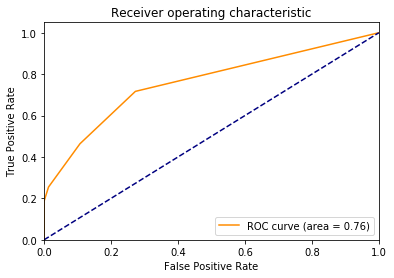

In [329]:
fpr, tpr, thresholds = roc_curve(popy, pop_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [300]:
pop_predictions.head()

0    0.705128
1    1.000000
2    1.000000
3    0.705128
4    1.000000
dtype: float64

Population attributes produced an ROC curve area of 0.76 and an Adjusted R-squared value of 0.238. Thus population is not a great predictor of whether or not a mushroom is poisonous by itself.

Next, I will look at habitat and how it affects the class attribute.

In [301]:
habX = data.iloc[:,112:119]
haby = data.iloc[:,0:1]

model = sm.OLS(haby, habX).fit()
hab_predictions = model.predict(habX)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                class_e   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     325.0
Date:                Mon, 25 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:49:47   Log-Likelihood:                -5016.4
No. Observations:                8124   AIC:                         1.005e+04
Df Residuals:                    8117   BIC:                         1.010e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
habitat_d      0.5972      0.008     74.648      0.000       0.582       0.613
habitat_g      0.6555      0.010     67.681      0.000       0.637       0.674
habitat_l      0.2885      0.016     18.537      0.000       0.258       0.319
habitat_m      0.8767      0.026     33.376      0.000       0.825       0.928
habitat_p      0.1189      0.013      8.958      0.000       0.093       0.145
habitat_u      0.2609      0.023     11.149      0.000       0.215       0.307
habitat_w      1.0000      0.032     30.870      0.000       0.936       1.064
==============================================================================
Omnibus:                    18856.348   Durbin-Watson:                   1.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              593.502
Skew:                          -0.169   Prob(JB):                    1.33e-129
Kurtosis:                       1.720   Cond. No.                         4.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

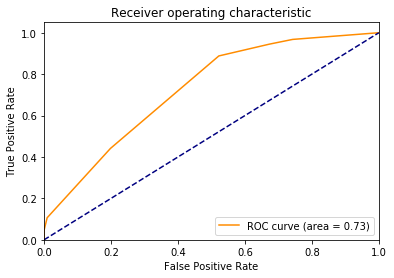

In [336]:
fpr, tpr, thresholds = roc_curve(haby, hab_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [302]:
hab_predictions.head()

0    0.260870
1    0.655493
2    0.876712
3    0.260870
4    0.655493
dtype: float64

The habitat attribute produced a ROC curve area of 0.73 and an Adjust R-squared value of 0.194 which again show that by itself, habitat is not a great predictor of whether or not a mushroom is poisonous.

### XGBoost

Next, I will move on to a new classification method using xgboost. I will again be trying to predict if a mushroom is edible or poisonous.

C:\Users\ditte\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ditte\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


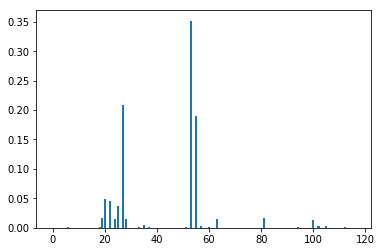

{'cap-shape_b': 0.0,
 'cap-shape_c': 0.0,
 'cap-shape_f': 0.0,
 'cap-shape_k': 0.0,
 'cap-shape_s': 0.0,
 'cap-shape_x': 0.0,
 'cap-surface_f': 0.001616503,
 'cap-surface_g': 0.0,
 'cap-surface_s': 2.2432692e-05,
 'cap-surface_y': 0.0,
 'cap-color_b': 0.0,
 'cap-color_c': 0.0,
 'cap-color_e': 0.0,
 'cap-color_g': 0.0,
 'cap-color_n': 0.0,
 'cap-color_p': 0.0,
 'cap-color_r': 0.0,
 'cap-color_u': 0.0,
 'cap-color_w': 0.0010613226,
 'cap-color_y': 0.01726796,
 'bruises_f': 0.049483035,
 'bruises_t': 0.0,
 'odor_a': 0.044884194,
 'odor_c': 0.0,
 'odor_f': 0.015654976,
 'odor_l': 0.037440166,
 'odor_m': 0.0,
 'odor_n': 0.209175,
 'odor_p': 0.015356497,
 'odor_s': 0.0,
 'odor_y': 0.0,
 'gill-attachment_a': 0.0,
 'gill-attachment_f': 0.0,
 'gill-spacing_c': 0.0011665765,
 'gill-spacing_w': 0.0,
 'gill-size_b': 0.00468193,
 'gill-size_n': 0.0,
 'gill-color_b': 0.001503842,
 'gill-color_e': 0.0,
 'gill-color_g': 0.0,
 'gill-color_h': 0.0,
 'gill-color_k': 0.0,
 'gill-color_n': 0.0,
 'gill-colo

In [306]:
# plot feature importance manually
from xgboost import XGBClassifier
from matplotlib import pyplot

xgb_data = pd.get_dummies(data=df, columns=['class','cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 
            'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
            'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 
            'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'])

X_xgb = xgb_data.drop(['class_e', 'class_p'], axis=1)
y_xgb = xgb_data.iloc[:,0:1]

model = XGBClassifier()
model.fit(X_xgb, y_xgb)
# feature importance and plots
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()
data_total = X_xgb.iloc[:,0:119]
data_total.columns
importance_dict = dict(zip(data_total.columns, model.feature_importances_))
importance_dict

The above output shows different importance values for each one of the attributes. As can be seen from the numbers and graph, the odor set and the stalk set appear to have the most significance in predicting whether or not a mushroom is poisonous. stalk_root_c is the single most important predictor with a value of 0.35178652 followed by odor_n at 0.209175 and stalk_root_r at 0.18919086. The original linear regression models did not have the stalk set to be one of the best predictors. In particular stalk_root_c and r did not have any significant values indicating a great prediction of whether a mushroom is poisonous or edible. Odor and odor_n (no odor) in particular on the other hand were shown to be great predictors in the original model as well as with xgb.

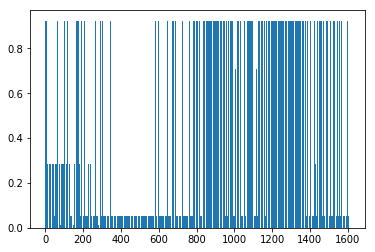

In [339]:
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)
plt.bar(range(len(preds)), preds)
plt.show()
# shows prediction on 1600 test subjects

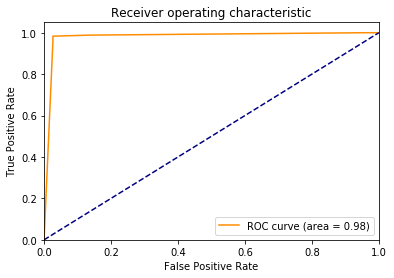

In [369]:
# getting test values to compare for ROC curve
roc_xgb = pd.read_csv('agaricus.txt.test', ' ')
roc_f = roc_xgb.iloc[:,0:1]
n_preds = np.delete(preds, 0)

fpr, tpr, thresholds = roc_curve(roc_f, n_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Summary

From the original linear regression models: 

Cap attributes     
 - ROC                    0.72  
 - Adjusted R-squared     0.142  
 
Bruises  
 - ROC                    0.75  
 - Adjusted R-squared     0.251  
 
Odor   
 - ROC                    0.99  
 - Adjusted R-squared     0.943 
 
Gill  
 - ROC                    0.94  
 - Adjusted R-squared     0.599  
 
Stalk  
 - ROC                    0.92  
 - Adjusted R-squared     0.555 
 
Veil  
 - ROC                    0.52  
 - Adjusted R-squared     0.023  
 
Ring  
 - ROC                    0.83  
 - Adjusted R-squared     0.380  
 
Spore  
 - ROC                    0.90  
 - Adjusted R-squared     0.566  
 
Population  
 - ROC                    0.76  
 - Adjusted R-squared     0.238  
 
Habitat  
 - ROC                    0.73  
 - Adjusted R-squared     0.194  
 
XGBoost on Training Data
 - ROC                    0.98

Most Important Attributes from Linear Regressions:  
1. Odor   
2. Gill  
3. Stalk     

Most Important Attributes from XGBoost:    
1. Odor  
2. Stalk  
3. Gill  


## Conclusion
The purpose of this lab was to be able to find out which physical attributes of a mushroom best predict if the mushroom is edible or poisonous. The results for both the initial linear regression models and XGBoost showed there to be a strong correlation with the three attributes categories of odor, gill, and stalk. The linear regression model produced a prediction that had an Adjusted R-squared value of 1.00 and a ROC cruve area of 1.00 meaning the model is essentially a perfect predictor of the mushroom dataset. 

The XGBoost model produced an ROC of 0.98 meaning the model is an overall great predictor of whether or not a mushroom is edible, but not quite as good as the original linear regression model using all of the attributes.

If you had to choice one attribute to determine whether a mushroom was edible or not, odor is overall the best idicator having an Adjust R-squared value of 0.943 and a ROC curve area of 0.99.

If I were going to do further work, I would try different classification models like random forests, decision tree, SVM, etc to find if any other models could produce a perfect fit. I would also experiment with the minimum number of attributes needed in order to get the perfect Adjusted R-square value of 1.00.
